 
# Import dependencies


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
%matplotlib qt
import os
import pandas as pd
import glob
import csv

from mne import pick_types, Annotations, create_info, find_events, Epochs
from mne.channels import make_standard_montage
from mne.io import RawArray
from mne.epochs import concatenate_epochs
from mne.decoding import CSP

from scipy.signal import welch
from mne.viz.topomap import _prepare_topo_plot, plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load one evaluation for one subject to explore the data

In [2]:
# create mne montage object
ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7',
            'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 
            'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
sfreq = 500
montage= make_standard_montage('easycap-M1')
info = create_info(ch_names, sfreq, montage=montage)

DigMontage is a superset of info. 74 in DigMontage will be ignored. The ignored channels are: {'F8', 'CP4', 'PO10', 'CPz', 'FC1', 'P8', 'F2', 'C1', 'CP6', 'TP8', 'P1', 'C5', 'PO7', 'Cz', 'F10', 'Fp2', 'Fpz', 'FC6', 'O2', 'FC2', 'CP2', 'F7', 'TP10', 'FT7', 'FC5', 'TP7', 'F9', 'T7', 'AF7', 'F1', 'Oz', 'P10', 'FT8', 'Fz', 'AF8', 'P4', 'P3', 'AF4', 'CP5', 'F6', 'F3', 'PO4', 'TP9', 'PO9', 'O10', 'AF3', 'F5', 'C4', 'FCz', 'F4', 'C3', 'C2', 'O1', 'PO8', 'AFz', 'P2', 'Fp1', 'FT10', 'Iz', 'T8', 'FT9', 'FC3', 'P7', 'FC4', 'O9', 'CP1', 'CP3', 'P6', 'P9', 'P5', 'POz', 'PO3', 'C6', 'Pz'}


In [3]:
# get subject1, series 1 data
path = os.getcwd() + '/grasp-and-lift-eeg-detection/train'
data_file = os.listdir(path)[92]
data_events = os.listdir(path)[30]
print(data_file)
print(data_events)

subj1_series1_data.csv
subj1_series1_events.csv


In [4]:
# create raw object
df = pd.read_csv(path + "/" + data_file)
data = df.drop(['id'], axis=1).to_numpy()
raw = RawArray(data.transpose(), info)

Creating RawArray with float64 data, n_channels=32, n_times=119496
    Range : 0 ... 119495 =      0.000 ...   238.990 secs
Ready.


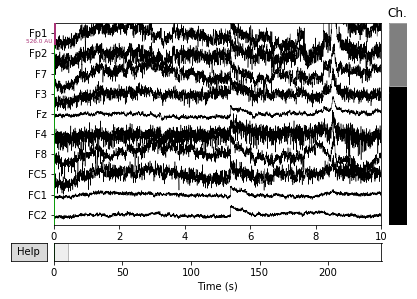

In [5]:
# plot raw object
fig = raw.plot( n_channels=10 , show_options=True) # plot the first 10 channels

In [6]:
def get_column_annotations(df, column_name, sfreq=500):
    '''Determine grasp-and-lift annotations from events dataframe

    :param df: The events dataframe
    :param column_name: The name of the column from which the data will be extracted
    :sfreq: The frequency of the recorder data
    :return: (onset, duration, description) for creating an annotations object
    '''

    onset = []
    duration = []
    description = []
    series = df[column_name].copy()
    id_start = len(series) # initiate the id to a value other than 0
    while True: # emulated do-while loop
        id_start = series.idxmax(1)
        if (id_start == 0):
            break
        i = id_start
        while (series[i] == 1):
            series[i] = 0
            i += 1
        onset.append(id_start/sfreq)
        duration.append((i-id_start)/sfreq)
        description.append(column_name)
    return (onset, duration, description)


In [7]:
# create events for mne annotations object
df = pd.read_csv(path + "/" + data_events)

onset, duration, description = [], [], []
for i in range(1,len(df.columns)):
    column_name = df.columns[i]
    out = get_column_annotations(df, column_name)
    onset += out[0]
    duration += out[1]
    description += out[2]


In [8]:
# create annotations object
my_annot = Annotations(onset=onset,
                           duration=duration,
                           description=description)
print(my_annot)
raw.set_annotations(my_annot)

<Annotations  |  204 segments : HandStart (34), FirstDigitTouch (34), BothStartLoadPhase (34)..., orig_time : None>


<RawArray  |  None, n_channels x n_times : 32 x 119496 (239.0 sec), ~29.2 MB, data loaded>

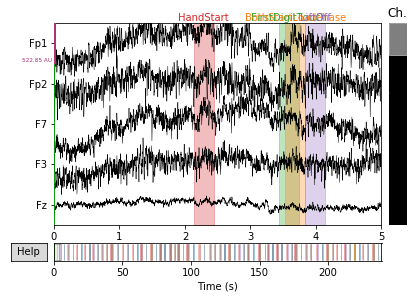

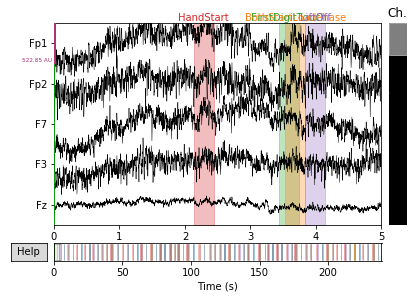

In [10]:
# plot raw object with events highlighted
raw.plot(n_channels=5, duration = 5)

### Analysing the data using the CSP (Common Spatial Pattern)
###### (code adapted from: https://www.kaggle.com/alexandrebarachant/common-spatial-pattern-with-mne)

In [11]:
# get the data file names for a specific subject
subject = 2
file = f'grasp-and-lift-eeg-detection/train/subj{subject}_series*_data.csv'
dirpath = os.path.join(os.getcwd(),file)
glob_object = glob.glob(dirpath)

In [12]:
def create_raw_from_csv(file):
    ''' Create a raw mne file from data provided in csv format
    :param file: The data file. No need to pass in the events file.
    :return: raw mne file
    '''

    # create data array
    data_df = pd.read_csv(file).drop(['id'], axis=1)
    file = file.replace('data','events')
    events_df = pd.read_csv(file).drop(['id'], axis=1)
    data_all = np.concatenate([data_df.to_numpy().transpose(), events_df.to_numpy().transpose()])

    # create info object
    ch_names = list(data_df.columns) + list(events_df.columns)
    # manually change the name of the 3rd event columns so mne won't complain about length
    ch_names[34] = "BothStartLoadPh" 
    ch_type = 32*['eeg'] + 6*['stim']
    montage = make_standard_montage('easycap-M1')
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
    info['description'] = file[file.rfind('\\')+1:file.rfind('_')]
    raw = RawArray(data_all,info,verbose=False)

    return raw


In [13]:
# record file index for each epoch
session = []
# type of epoch: 1=hand movement, -1=hand static
y = []
# store all epochs
epochs_all = []

for i,file in enumerate(glob_object):
    print('------------')
    print(file)
    print('------------')
    # create raw file
    raw = create_raw_from_csv(file) 
    # select eeg channels
    picks = pick_types(raw.info,eeg=True) 
    # filter for miu and beta bands
    raw.filter(7,35, picks=picks, method='iir', n_jobs=-1, verbose=False) 
    # find events before Replace (when hand movement stops)
    events = find_events(raw,stim_channel='Replace', verbose=False) 
    
    # identify individual trials (called Epochs in MNE) from the raw files [-2, -0.5] seconds before Replace
    epochs_movement = Epochs(raw, events, {'during' : 1}, -2, -0.5, proj=False,
                        picks=picks, baseline=None, preload=True,
                        verbose=False)
    # append epochs from current raw file to main epochs list
    epochs_all.append(epochs_movement)
    # add file index identifier 
    session.extend([i]*len(epochs_movement))
    # add hand movement indentifier
    y.extend([1]*len(epochs_movement))  
    
    
    # identify individual trials (called Epochs in MNE) from the raw files [0.5, 2] seconds after Replace
    epochs_static = Epochs(raw, events, {'after' : 1}, 0.5, 2, proj=False,
                        picks=picks, baseline=None, preload=True,
                        verbose=False)
    #need to shift epoch time in order to have same time windows for both types of epochs
    epochs_static.shift_time(-2.5)
    # append epochs from current raw file to main epochs list
    epochs_all.append(epochs_static)
    # add file index identifier 
    session.extend([i]*len(epochs_static))
    # add hand movement indentifier
    y.extend([-1]*len(epochs_static))
    


------------
/home/cinetic-vr/EEG/grasp-and-lift-eeg-detection/train/subj2_series7_data.csv
------------
DigMontage is a superset of info. 42 in DigMontage will be ignored. The ignored channels are: {'F6', 'CP4', 'PO4', 'CPz', 'O10', 'AF3', 'F5', 'F2', 'C1', 'FCz', 'TP8', 'P1', 'C5', 'C2', 'PO7', 'F10', 'PO8', 'Fpz', 'AFz', 'P2', 'PO3', 'FT7', 'TP7', 'FT10', 'Iz', 'F9', 'FT9', 'AF7', 'F1', 'FC3', 'P10', 'FT8', 'FC4', 'O9', 'CP3', 'P6', 'P9', 'AF8', 'P5', 'POz', 'AF4', 'C6'}
------------
/home/cinetic-vr/EEG/grasp-and-lift-eeg-detection/train/subj2_series5_data.csv
------------
DigMontage is a superset of info. 42 in DigMontage will be ignored. The ignored channels are: {'F6', 'CP4', 'PO4', 'CPz', 'O10', 'AF3', 'F5', 'F2', 'C1', 'FCz', 'TP8', 'P1', 'C5', 'C2', 'PO7', 'F10', 'PO8', 'Fpz', 'AFz', 'P2', 'PO3', 'FT7', 'TP7', 'FT10', 'Iz', 'F9', 'FT9', 'AF7', 'F1', 'FC3', 'P10', 'FT8', 'FC4', 'O9', 'CP3', 'P6', 'P9', 'AF8', 'P5', 'POz', 'AF4', 'C6'}
------------
/home/cinetic-vr/EEG/grasp-an

In [14]:
epochs = concatenate_epochs(epochs_all)
X = epochs.get_data()
y = np.array(y)

In [15]:
# normalization 

X_norm = np.empty((32,0))
for i in range(520):
    temp = X[i,:,:]
    X_norm = np.concatenate([X_norm,temp],axis=1)
MEAN = X_norm.mean(1).reshape(32,1)
ST_DEV = X_norm.std(1).reshape(32,1)

for i in range(520):
    X[i,:,:] = (X[i,:,:] - MEAN)/ST_DEV

In [16]:
csp = CSP()
csp.fit(X,y)

Computing data rank from raw with rank=None
    Using tolerance 12 (2.2e-16 eps * 32 dim * 1.6e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank=None
    Using tolerance 13 (2.2e-16 eps * 32 dim * 1.8e+15  max singular value)
    Estimated rank (mag): 32
    MAG: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating covariance using EMPIRICAL
Done.


CSP(cov_est='concat', cov_method_params=None, log=None, n_components=4,
  norm_trace=False, rank=None, reg=None, transform_into='average_power')

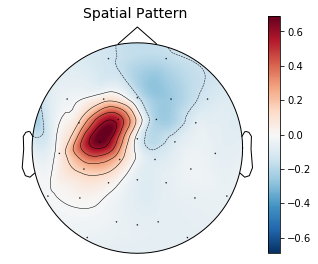

In [17]:
po = []
for x in X:
    f,p = welch(np.dot(csp.filters_[0,:].T,x), 500, nperseg=512)
    po.append(p)
po = np.array(po)

# prepare topoplot
_,epos,_,_,_ = _prepare_topo_plot(epochs,'eeg',None)

# plot first pattern
pattern = csp.patterns_[0,:]
pattern -= pattern.mean()
ix = np.argmax(abs(pattern))
# the parttern is sign invariant.
# invert it for display purpose
if pattern[ix]>0:
    sign = 1.0
else:
    sign = -1.0

fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4))
title = 'Spatial Pattern'
fig.suptitle(title, fontsize=14)
img, _ = plot_topomap(sign*pattern,epos,axes=ax_topo,show=False)

divider = make_axes_locatable(ax_topo)
# add axes for colorbar
ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(img, cax=ax_colorbar)
 
 